In [129]:
import glob,json,os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths=glob.glob('../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

In [119]:
validation_annotations=json.load(open('../data/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json'))
validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [120]:
validation_annotations_dict={x['image_id']:x['caption'][0] for x in validation_annotations}


In [130]:
img_paths_basenames=[os.path.basename(x) for x in img_paths]
img_captions=[validation_annotations_dict[x] for x in img_paths_basenames]

加载Clip模型

In [122]:
from transformers import ChineseCLIPProcessor,ChineseCLIPModel
import torch

model=ChineseCLIPModel.from_pretrained('../model/clip')
processor=ChineseCLIPProcessor.from_pretrained('../model/clip')


图像编码

In [123]:
import random
idx=random.randint(0, 3000)
idx

image_feat=[]
batch_size=10

imgs=[Image.open(path) for path in img_paths[idx*batch_size:(idx+1)*batch_size]]
inputs=processor(images=imgs,return_tensors="pt")
with torch.no_grad():
    image_features=model.get_image_features(**inputs)
    image_features=image_features.data.numpy()
    image_feat.append(image_features)


image_feat=np.vstack(image_feat)#垂直堆叠数组；例如（10,512），（10,512），（10,512）堆叠成（30,512）
image_feat=normalize(image_feat)
image_feat.shape


(10, 512)

文本编码

In [124]:
text_feat=[]
texts=[text for text in img_captions[idx*batch_size:(idx+1)*batch_size]]
inputs=processor(text=texts,return_tensors="pt",padding=True)
with torch.no_grad():
    text_features=model.get_text_features(**inputs)
    text_features=text_features.data.numpy()
    text_feat.append(text_features)

text_feat=np.vstack(text_feat)#垂直堆叠数组；例如（10,512），（10,512），（10,512）堆叠成（30,512）
text_feat=normalize(text_feat)
text_feat.shape

(10, 512)

相似度计算

In [125]:
query_idx = 0
sim_result = np.dot(text_feat[query_idx], image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][0:3] #sim_result.argsort()表示获取相似度从小到大的索引，[::-1]表示反转成从大到小的索引
sim_idx

array([0, 5, 6], dtype=int64)

In [126]:
img_captions=img_captions[idx*batch_size:(idx+1)*batch_size]
img_captions

['一个人前面有一对戴着墨镜的男女走在整洁的道路上',
 '一个穿着球衣的人按着一个人的头跳跃在宽阔的运动场上',
 '瑜伽室里一个穿着格子衣服的女人旁边有两个女人在帮一个躺在垫子上的女人练习瑜伽',
 '一个穿着深色连衣裙的女人在溜冰场上表演滑冰',
 '两个衣着各异的男人站在大厅内的展板前',
 '路边的人行道上站着一个老人右手拿着鸟笼左手扶着自行车',
 '草地上有一个穿着深色上衣的男人在放马',
 '一个戴着眼镜的男人在房间里弹钢琴',
 '房间里有一个盘着腿的女人坐在吊椅上看书',
 '敞亮的房屋里有两个身穿黑色裤子的人在跳舞']

In [127]:
img_paths=img_paths[idx*batch_size:(idx+1)*batch_size]
img_paths

['../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f82db21f6f33e3e760825494b0ebfbe56b446c3.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f83ce33b701f1f5e55f388a9463d99710abee50.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f84c641cb1af4525f6134250caebd5e9ccbdfff.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f865f7860d68b1370bbbeb49620ee27a120f273.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f8a42602063b631dd03791af377e0c4f71fbb2d.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f8c9f87b7e7866e8bbd97e8c41c44a75fee0e42.jpg',
 '../data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\7f8dac79dab21e0aa194e18a28baebbe8bb9a557.jpg',
 '../data/ai_challenger_caption_validation_20170910/cap

输入文本:  一个人前面有一对戴着墨镜的男女走在整洁的道路上


([], [])

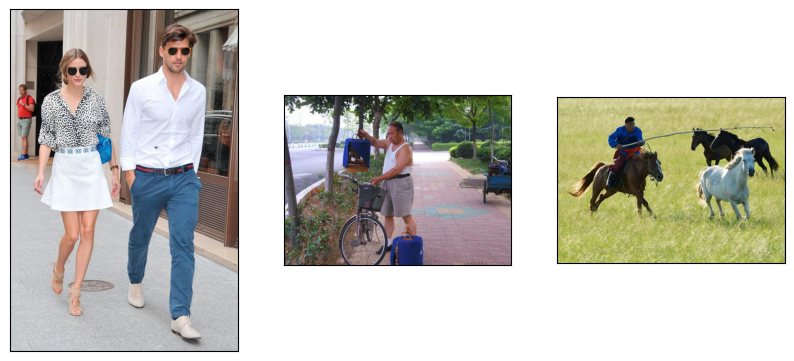

In [128]:

print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])